<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/inverseProblems/linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Linear Regression
###David Brady
### University of Arizona

Section 3.3 of **Computational Imaging**

This notebook considers linear estimators for $\mathbf{f}$ from $\mathbf{g}=\mathbf{Hf}+\mathbf{n}$, including ordinary least squares, truncated SVD and Tikhonov estimators. 

### Python modules

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.linalg import toeplitz
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams.update({'font.size': 22})

### Installation of the Chianti database of astrophysical data

CHIANTI consists of a database of atomic data that can be used to interpret spectral lines and continua emitted from high-temperature, optically-thin astrophysical sources. For more information see [the database github page](https://chianti-atomic.github.io/index.html) We use the database here to generate example 1D signals

In [2]:
!wget https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
!mkdir dbase
!tar xvf CHIANTI_10.0.1_database.tar.gz -C dbase/

--2021-09-03 00:15:44--  https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
Resolving download.chiantidatabase.org (download.chiantidatabase.org)... 70.32.23.63
Connecting to download.chiantidatabase.org (download.chiantidatabase.org)|70.32.23.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888202017 (847M) [application/x-gzip]
Saving to: ‘CHIANTI_10.0.1_database.tar.gz’

CHIANTI_10.0.1_data 100%[===================>] 847.05M  27.9MB/s    in 31s     

2021-09-03 00:16:16 (27.0 MB/s) - ‘CHIANTI_10.0.1_database.tar.gz’ saved [888202017/888202017]

README_CHIANTI
VERSION
abundance/
abundance/sun_coronal_2012_schmelz_ext.abund
abundance/cosmic_1973_allen.abund
abundance/sun_photospheric_2011_caffau.abund
abundance/sun_photospheric_2015_scott.abund
abundance/unity.abund
abundance/sun_coronal_1999_fludra_ext.abund
abundance/sun_photospheric_1998_grevesse.abund
abundance/sun_coronal_1992_feldman_ext.abund
abundance/sun_coronal_1999_fludra.abund
ab

In [3]:
!pip3 install ChiantiPy
!pip3 install ipyparallel
%env XUVTOP=/content/dbase/

     |████████████████████████████████| 189 kB 13.2 MB/s 
     |████████████████████████████████| 199 kB 17.1 MB/s 
env: XUVTOP=/content/dbase/


In [4]:
import ChiantiPy.core as ch

 ChiantiPy version 0.11.0 
 using cli
 using CLI for selections


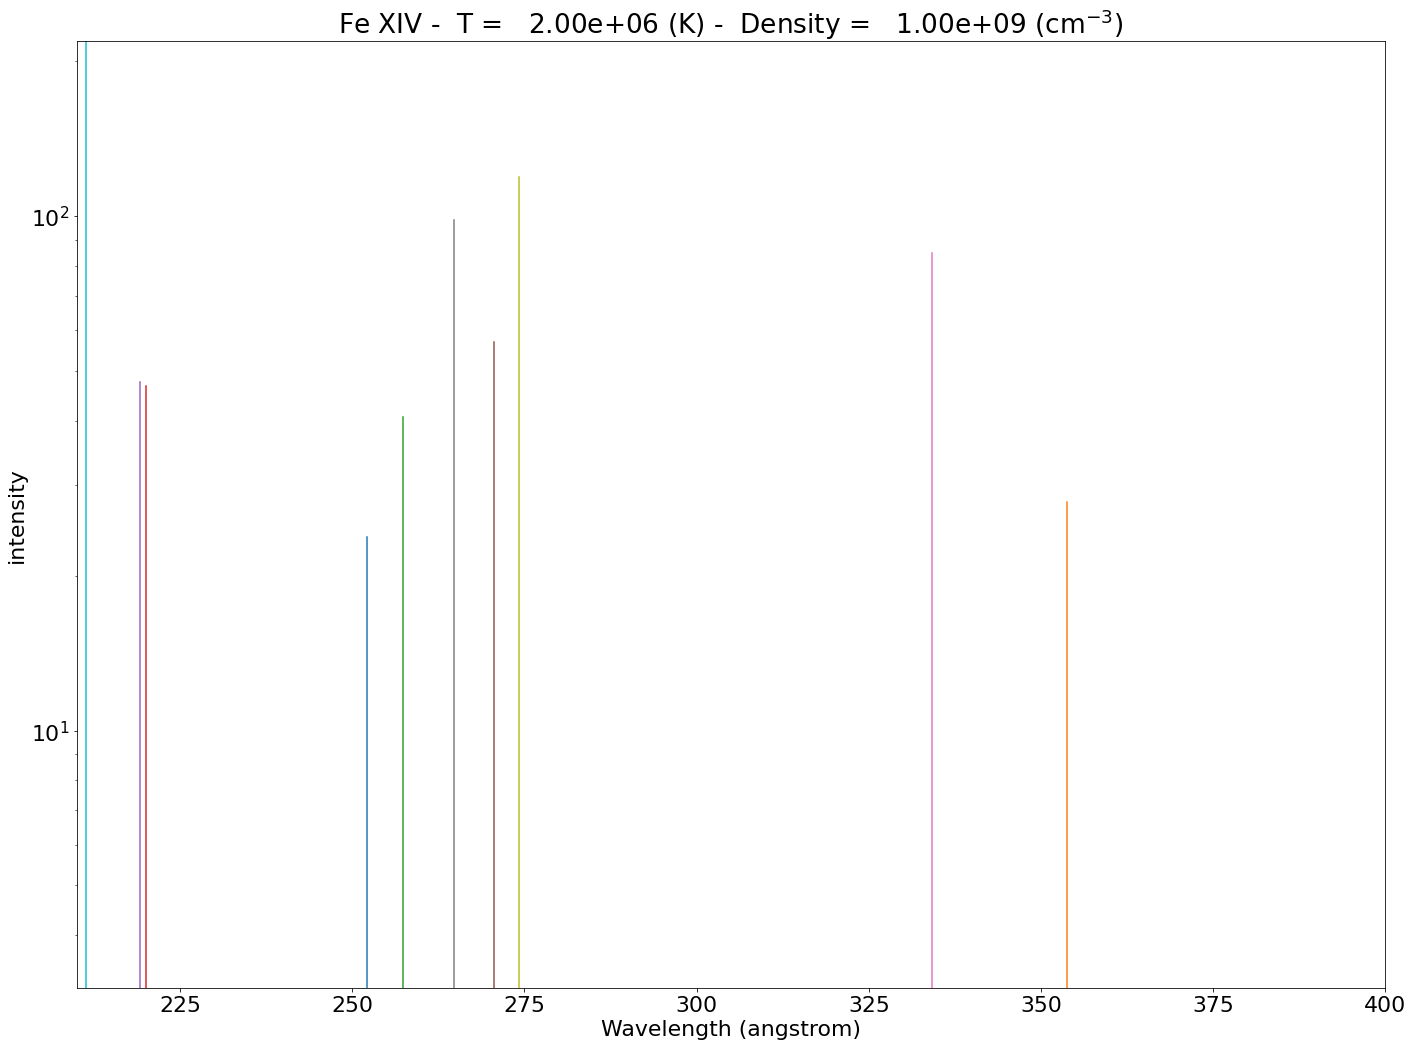

In [7]:
t=2000000
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9, em=1.e+27)
fe14.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe14.spectrum(wvl)

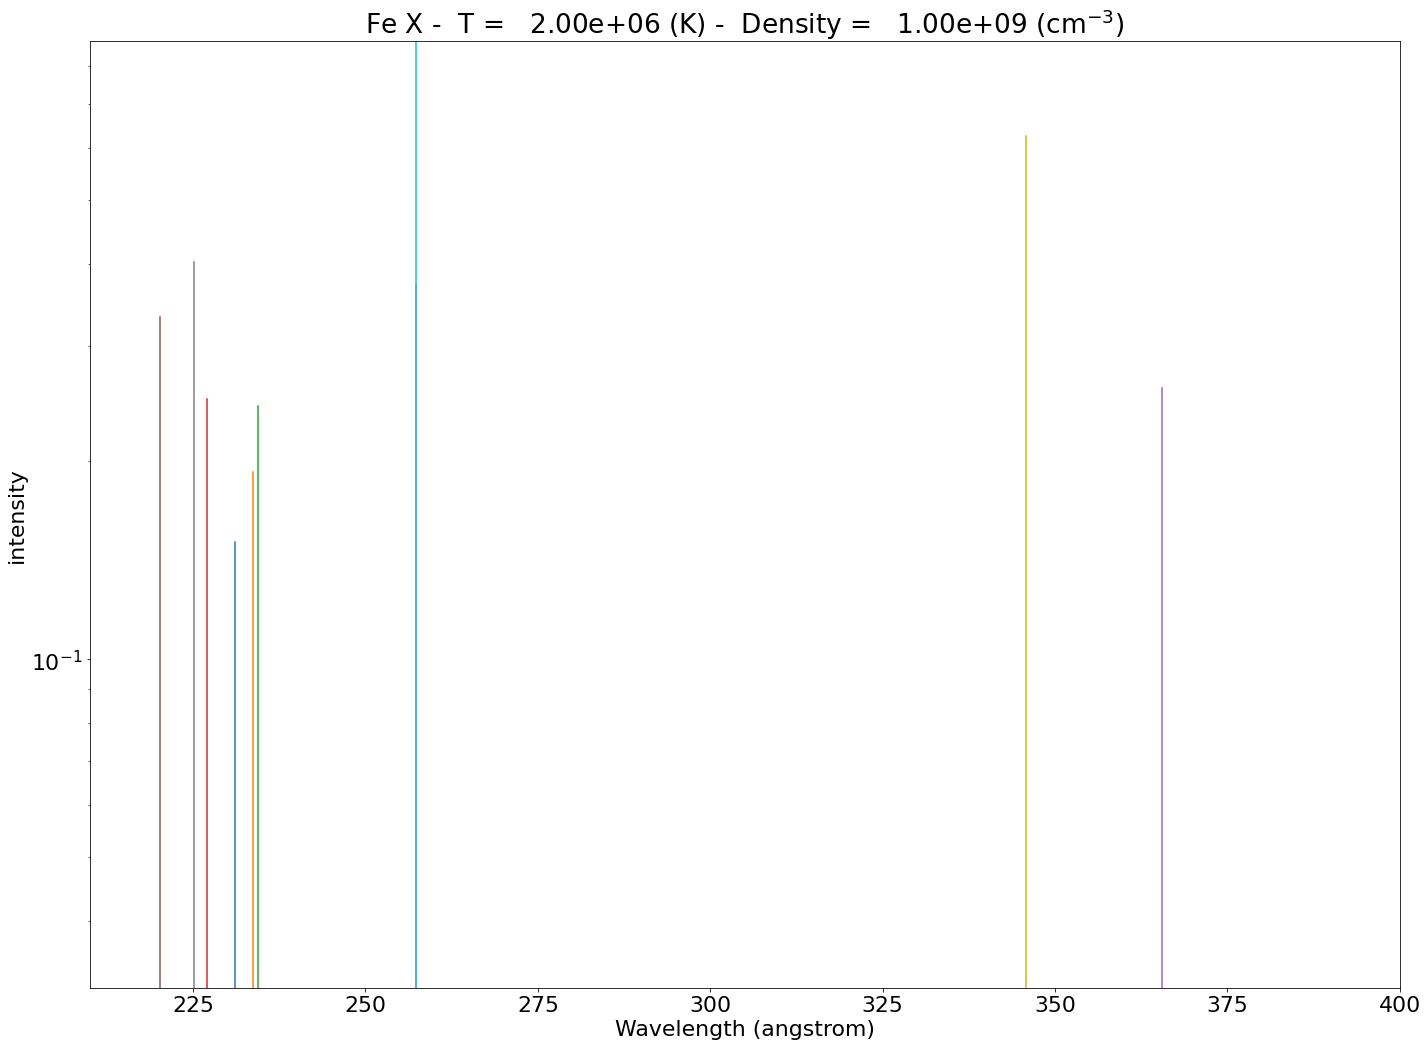

In [8]:
t=2000000
fe10 = ch.ion('fe_10', temperature=t, eDensity=1.e+9, em=1.e+27)
fe10.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe10.spectrum(wvl)

##  Random Matrices

### full rank matrix with no noise

Text(0.5, 1.0, 'Singular value spectrum of H')

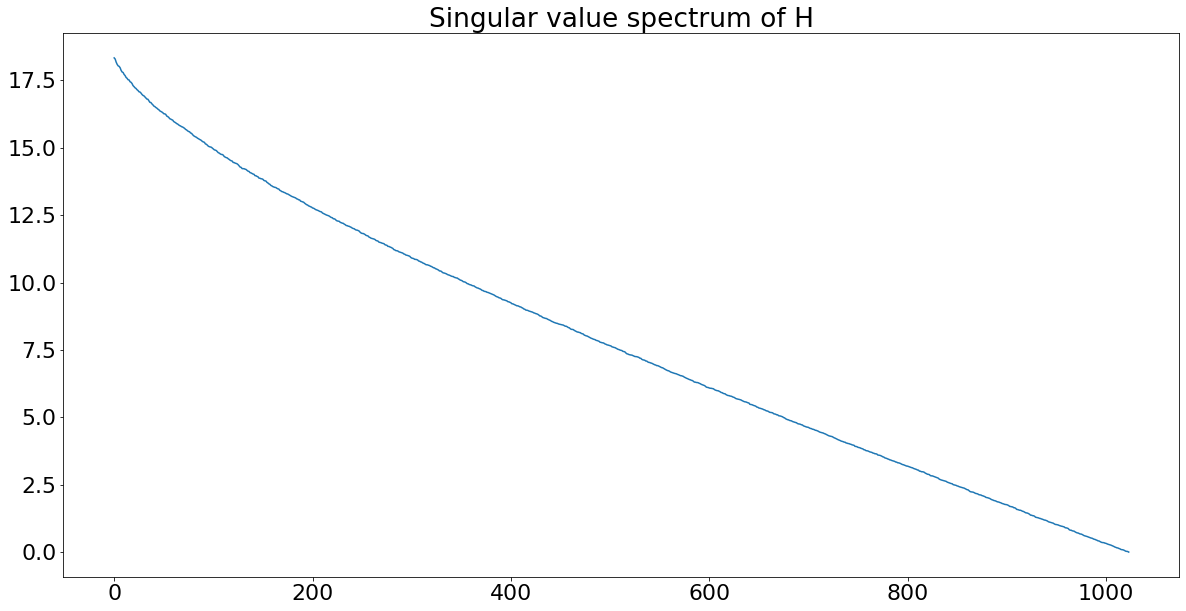

In [ ]:
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
plt.plot(lam)
plt.title('Singular value spectrum of H')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'true spectrum')

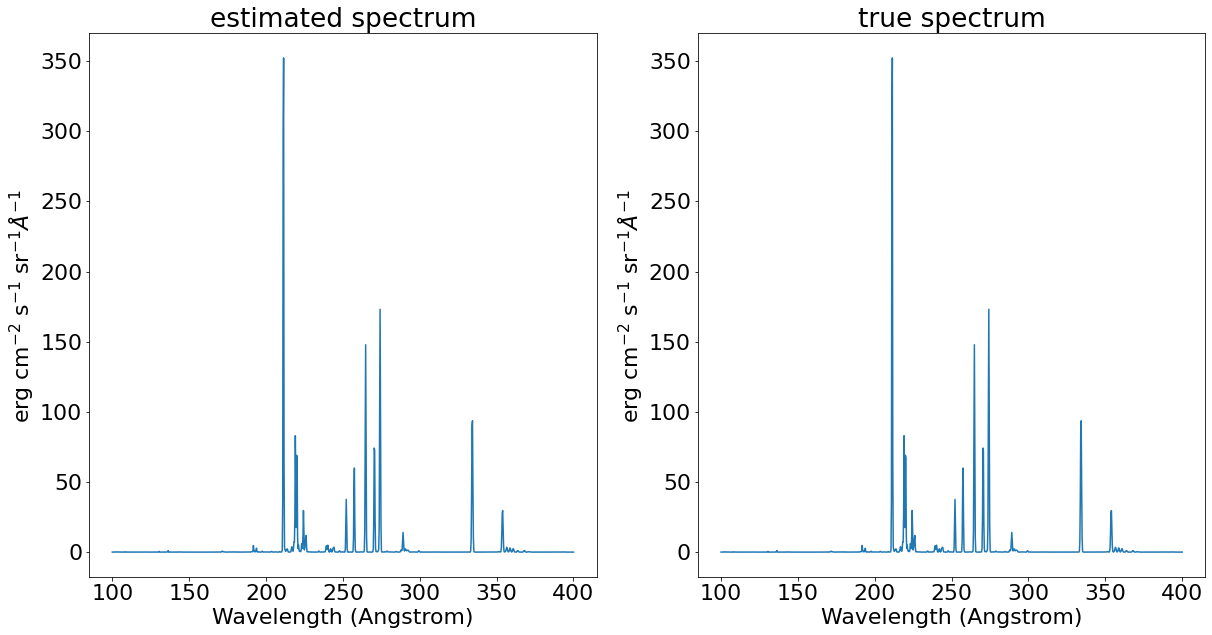

In [ ]:
fe=np.linalg.lstsq(H, np.matmul(H,fe14.Spectrum['intensity']))[0]
plt.subplot(1,2,1)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('estimated spectrum')
plt.subplot(1,2,2)
plt.plot(wvl,fe14.Spectrum['intensity'])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('true spectrum')

### 3/4 rank matrix with no noise

Text(0.5, 1.0, 'Singular value spectrum of H')

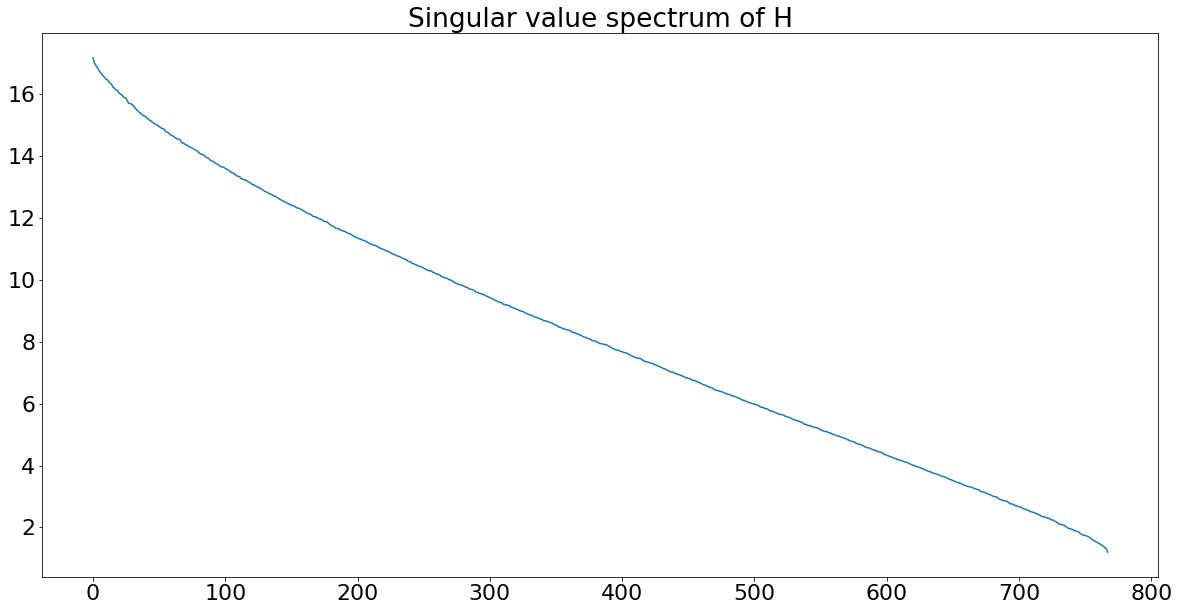

In [ ]:
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=768
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
plt.plot(lam)
plt.title('Singular value spectrum of H')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'true spectrum')

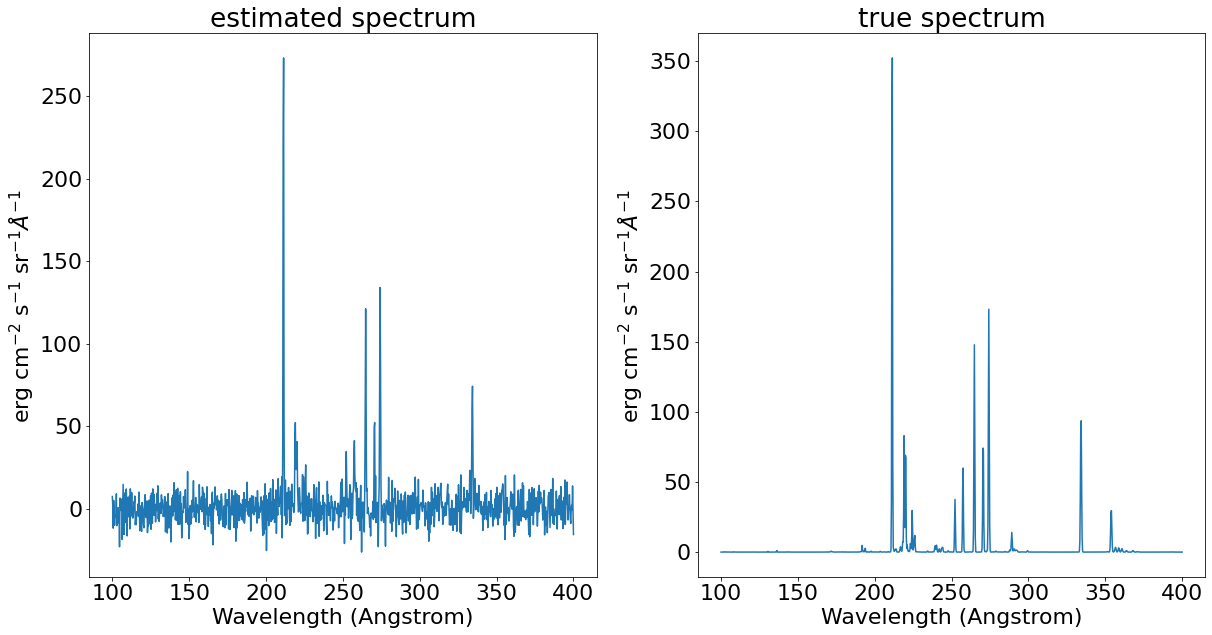

In [ ]:
fe=np.linalg.lstsq(H, np.matmul(H,fe14.Spectrum['intensity']))[0]
plt.subplot(1,2,1)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('estimated spectrum')
plt.subplot(1,2,2)
plt.plot(wvl,fe14.Spectrum['intensity'])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('true spectrum')

### Full rank matrix with additive Gaussian noise

Text(0.5, 1.0, 'Singular value spectrum of H')

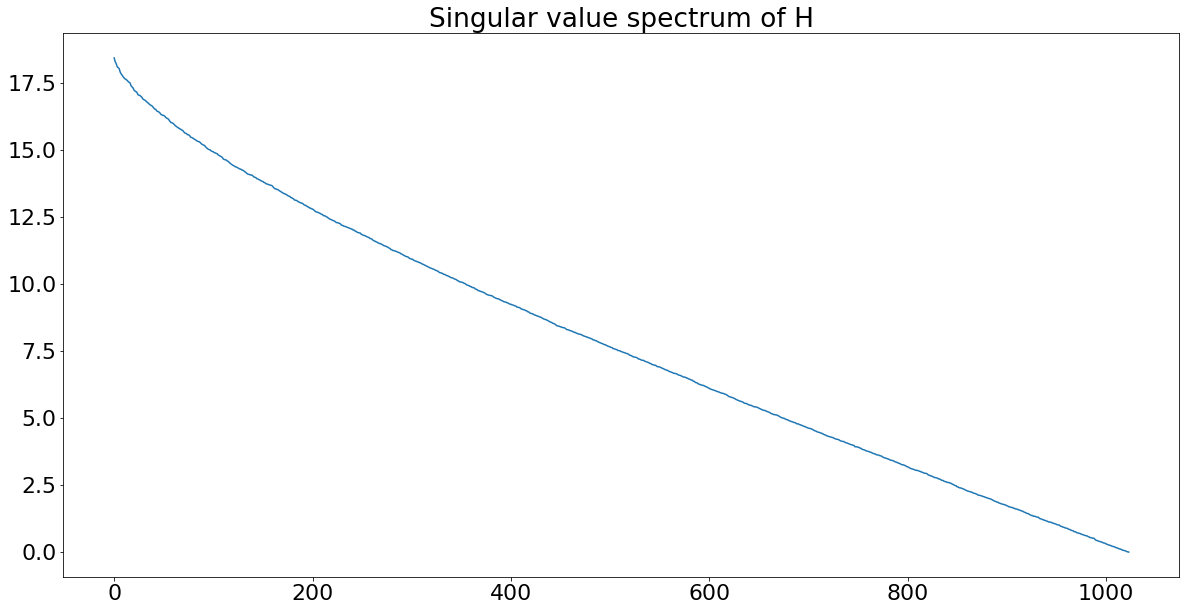

In [ ]:
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
plt.plot(lam)
plt.title('Singular value spectrum of H')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'true spectrum')

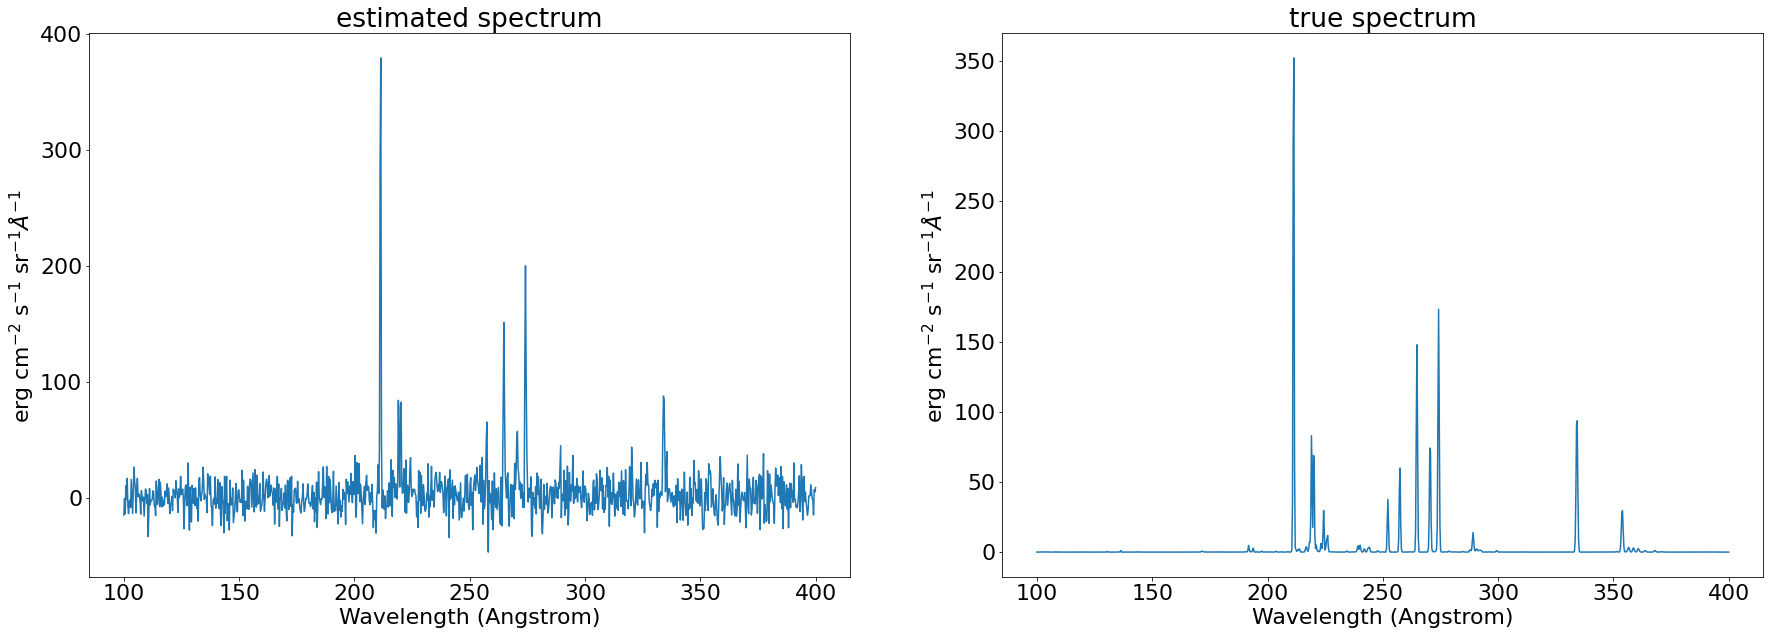

In [18]:
fe=np.linalg.lstsq(H, np.matmul(H,fe14.Spectrum['intensity'])+1*np.random.normal(scale=1,size=(1024)))[0]
plt.subplot(1,2,1)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('estimated spectrum')
plt.subplot(1,2,2)
plt.plot(wvl,fe14.Spectrum['intensity'])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('true spectrum')

### Full rank matrix with additive Gaussian noise, truncated SVD and Tikhonov reconstruction 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

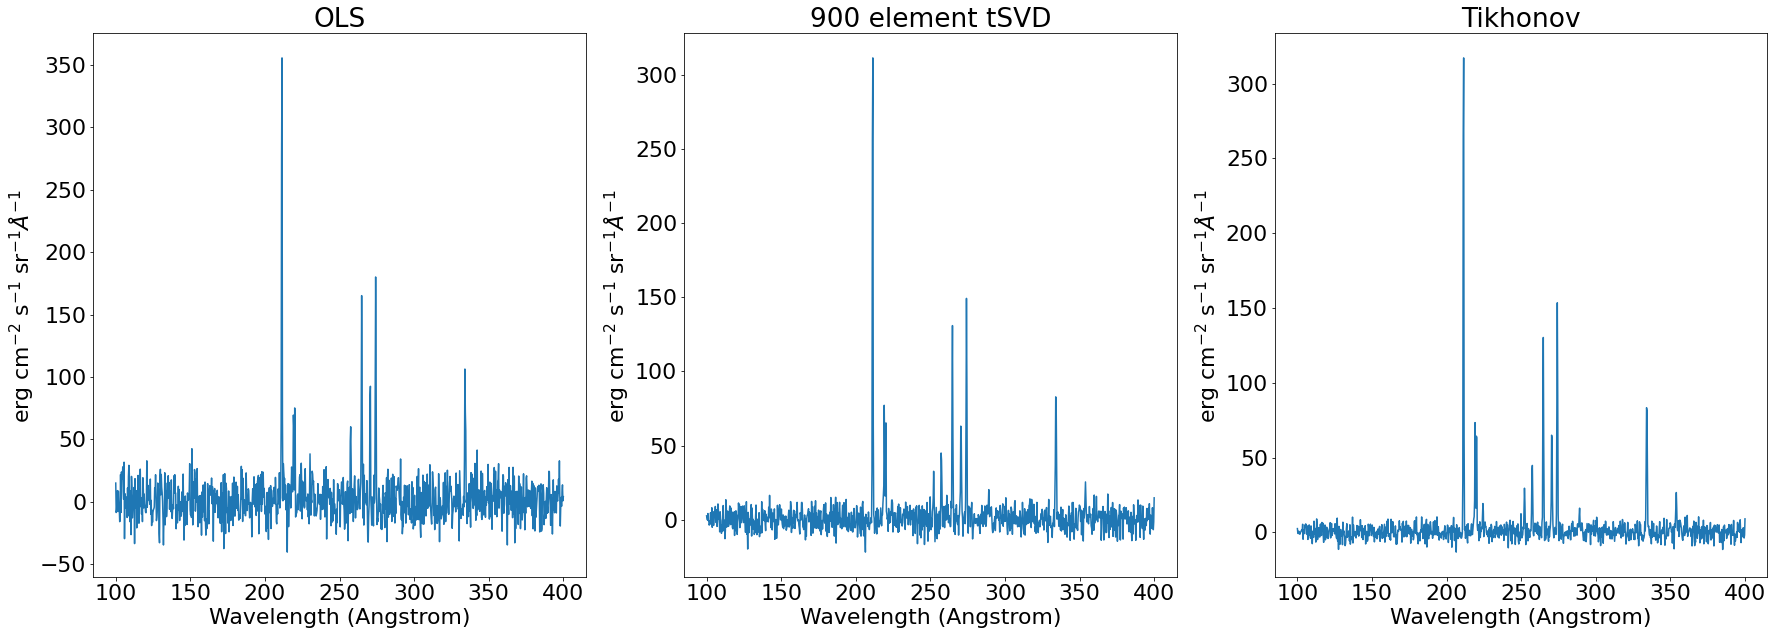

In [24]:
plt.rcParams['figure.figsize'] = [30, 10]
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
noiseLevel=3
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
meas=np.matmul(H,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))
#
#
plt.subplot(1,3,1)
fe=np.linalg.lstsq(H,meas)[0]
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('OLS')
plt.subplot(1,3,2)
reduceRank=900
Hr=np.matmul(np.matmul(np.transpose(vh[0:reduceRank,:]),np.diag(1./lam[0:reduceRank])),np.transpose(u[:,0:reduceRank]))
fe=np.matmul(Hr, meas)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('900 element tSVD')
plt.subplot(1,3,3)
lpam=1
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), meas)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('Tikhonov')
plt.savefig('randomLinear.pdf')
files.download('randomLinear.pdf')

### Additive Gaussian noise, truncated SVD reconstruction, smooth sinusoidal function

Text(0.5, 1.0, '700 elements')

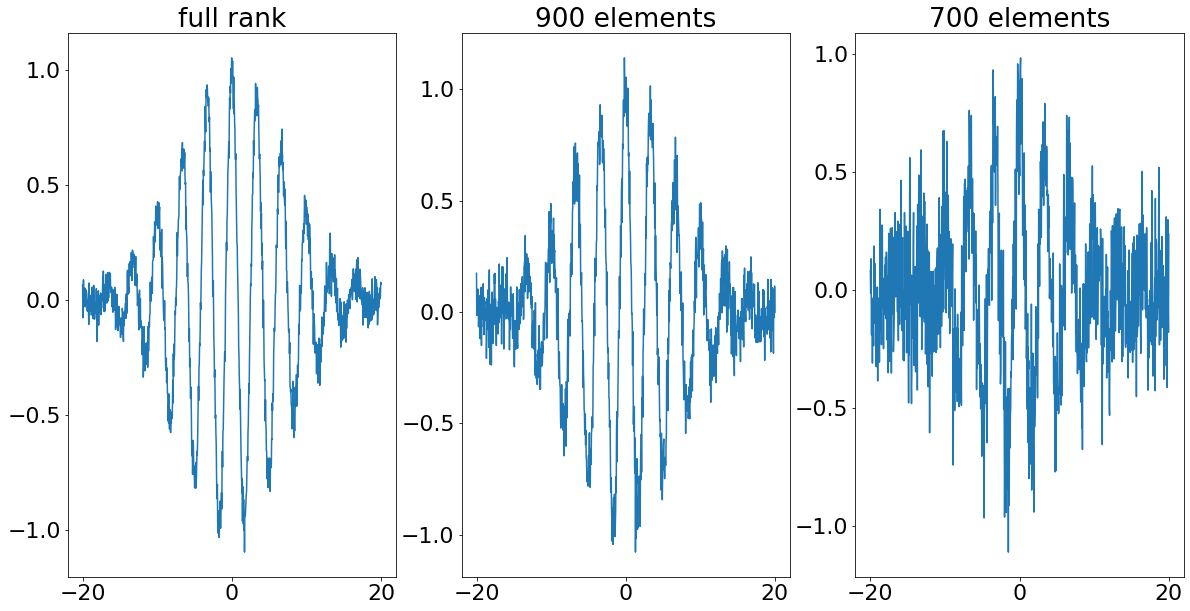

In [ ]:

#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
noiseLevel=.05
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
xD=np.linspace(-20,20,1024)
fSig=np.exp(-xD**2/100)*np.cos(2*np.pi*xD*0.3)
#
#
plt.subplot(1,3,1)
reduceRank=1024
Hr=np.matmul(np.matmul(np.transpose(vh[0:reduceRank,:]),np.diag(1./lam[0:reduceRank])),np.transpose(u[:,0:reduceRank]))
fe=np.matmul(Hr, (np.matmul(H,fSig+noiseLevel*np.random.normal(scale=1,size=(1024)))))
plt.plot(xD,fe)
plt.title('full rank')
plt.subplot(1,3,2)
reduceRank=1000
Hr=np.matmul(np.matmul(np.transpose(vh[0:reduceRank,:]),np.diag(1./lam[0:reduceRank])),np.transpose(u[:,0:reduceRank]))
fe=np.matmul(Hr, (np.matmul(H,fSig+noiseLevel*np.random.normal(scale=1,size=(1024)))))
plt.plot(xD,fe)
plt.title('900 elements')
plt.subplot(1,3,3)
reduceRank=700
Hr=np.matmul(np.matmul(np.transpose(vh[0:reduceRank,:]),np.diag(1./lam[0:reduceRank])),np.transpose(u[:,0:reduceRank]))
fe=np.matmul(Hr, (np.matmul(H,fSig+noiseLevel*np.random.normal(scale=1,size=(1024)))))
plt.plot(xD,fe)
plt.title('700 elements')


### Tikhonov regularization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0.5, 1.0, 'Tikhonov Regularized')

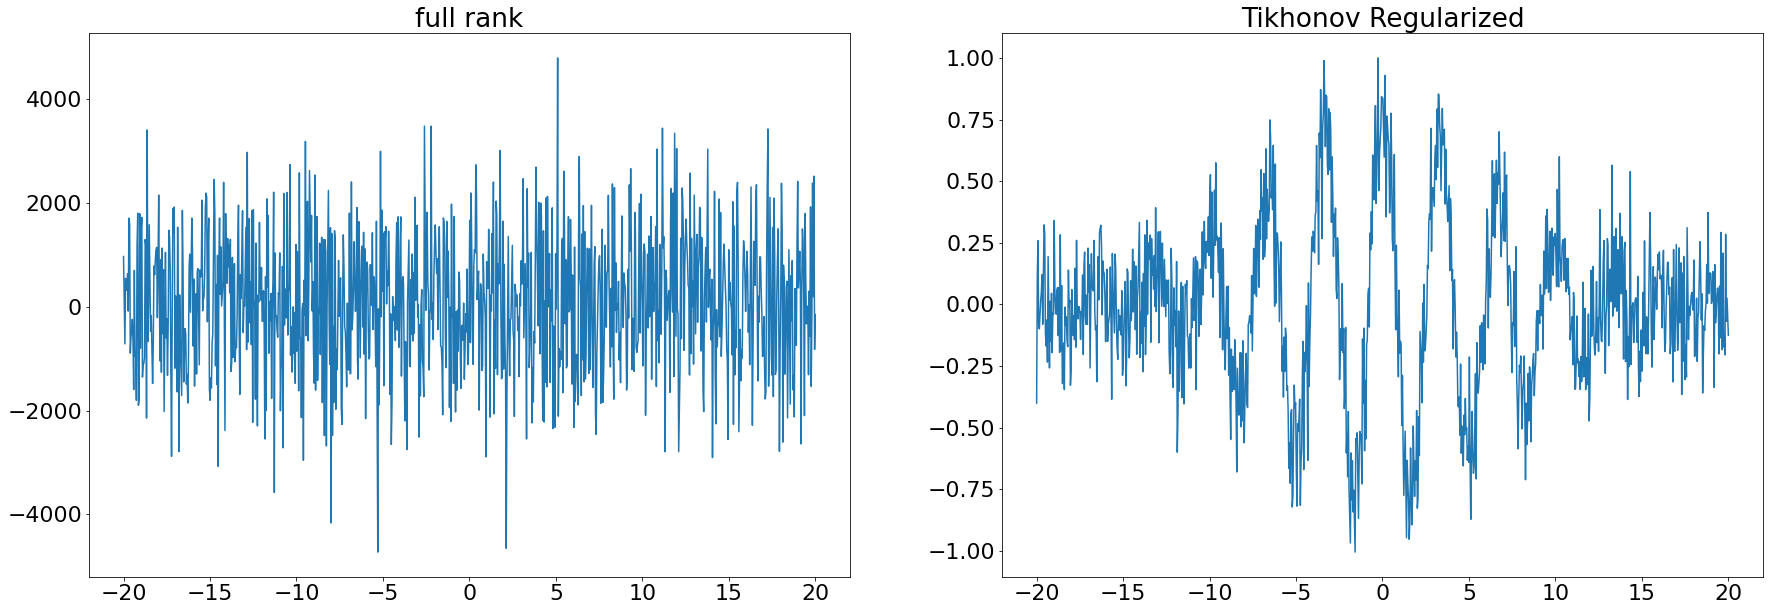

In [28]:

#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
noiseLevel=.2
lpam=1
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
badRank=800
H=np.matmul(np.matmul(u[:,0:badRank],np.diag(lam[0:badRank])),vh[0:badRank,:])+0.05*np.matmul(np.matmul(u[:,badRank:1024],np.diag(lam[badRank:1024])),vh[badRank:1024,:])
xD=np.linspace(-20,20,1024)
fSig=np.exp(-xD**2/100)*np.cos(2*np.pi*xD*0.3)
#
#
plt.subplot(1,2,1)
fe=np.linalg.lstsq(H, np.matmul(H,fSig)+noiseLevel*np.random.normal(scale=1,size=(1024)))[0]
plt.plot(xD,fe)
plt.title('full rank')
plt.subplot(1,2,2)
reduceRank=800
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), (np.matmul(H,fSig)+noiseLevel*np.random.normal(scale=1,size=(1024))))
plt.plot(xD,fe)
plt.title('Tikhonov Regularized')


## Shift invariant measurement kernel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

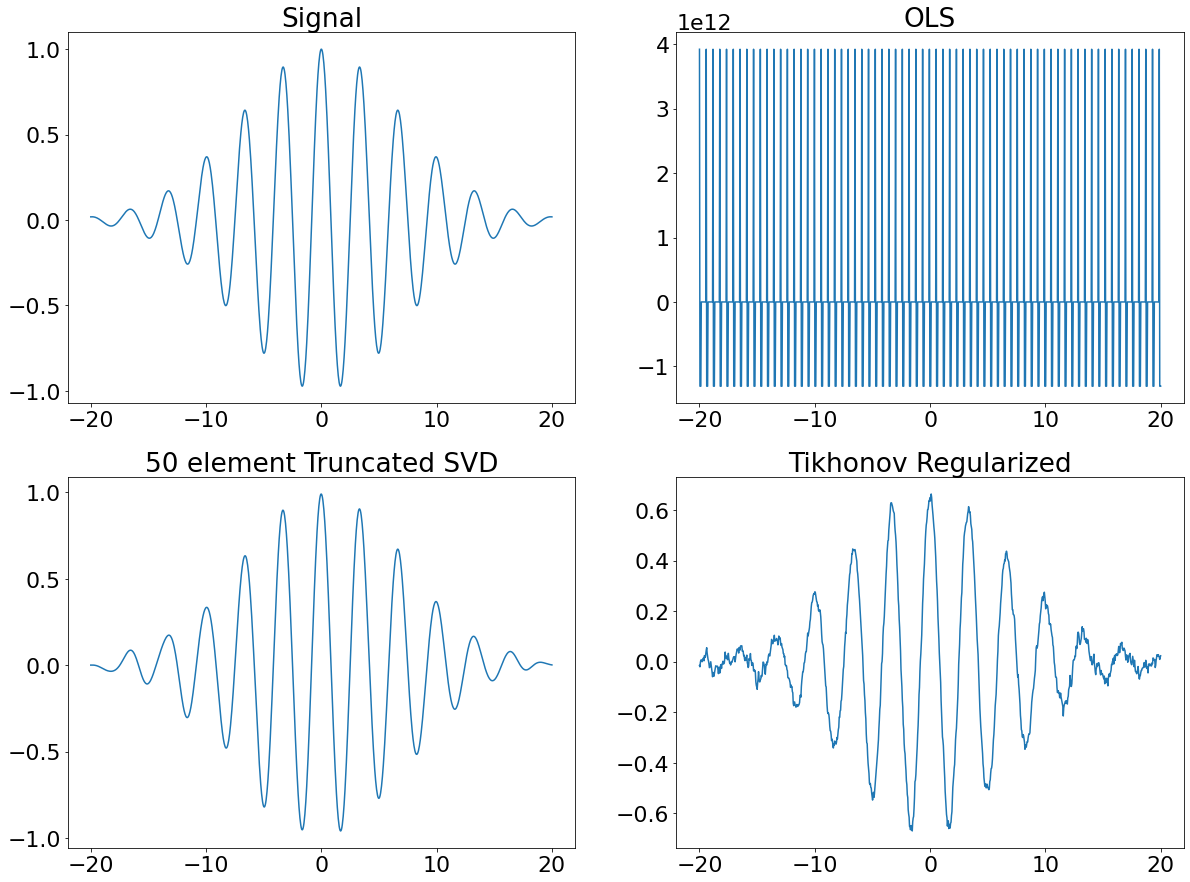

In [43]:
plt.rcParams['figure.figsize'] = [20, 15]
c=np.zeros(1024)
c[0]=1
r=c
r[0:8]=1
H=toeplitz(c,r)
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=1024
noiseLevel=1
lpam=10
#H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)
badRank=800
H=np.matmul(np.matmul(u[:,0:badRank],np.diag(lam[0:badRank])),vh[0:badRank,:])+0.05*np.matmul(np.matmul(u[:,badRank:1024],np.diag(lam[badRank:1024])),vh[badRank:1024,:])
xD=np.linspace(-20,20,1024)
fSig=np.exp(-xD**2/100)*np.cos(2*np.pi*xD*0.3)
#
#
plt.subplot(2,2,1)
plt.plot(xD,fSig)
plt.title('Signal')
plt.subplot(2,2,2)
fe=np.linalg.lstsq(H, np.matmul(H,fSig)+noiseLevel*np.random.normal(scale=1,size=(1024)))[0]
plt.plot(xD,fe)
plt.title('OLS')
plt.subplot(2,2,4)
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), (np.matmul(H,fSig)+noiseLevel*np.random.normal(scale=1,size=(1024))))
plt.plot(xD,fe)
plt.title('Tikhonov Regularized')
plt.subplot(2,2,3)
reduceRank=50
Hr=np.matmul(np.matmul(np.transpose(vh[0:reduceRank,:]),np.diag(1./lam[0:reduceRank])),np.transpose(u[:,0:reduceRank]))
fe=np.matmul(Hr, (np.matmul(H,fSig)+noiseLevel*np.random.normal(scale=1,size=(1024))))
plt.plot(xD,fe)
plt.title('50 element Truncated SVD')
plt.savefig('lowPassLinear.pdf')
files.download('lowPassLinear.pdf')
